# 2025 APMCM Problem B - Question 1
## Modeling and Optimization of Radiative Cooling Technology
### Analysis of PDMS Thin Film Emissivity

**Objective:**
Establish mathematical models to study the emissivity of Polydimethylsiloxane (PDMS) thin films as a function of wavelength ($\lambda$) and thickness ($d$).

**Models Used:**
1.  **Beer-Lambert Law Model (Simplified):** Based on geometric optics, considering absorption and surface reflection.
2.  **Transfer Matrix Method (TMM) (Advanced):** Based on wave optics, considering interference effects and multi-layer structures.

导入库与数据预处理

In [116]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

# 设置绘图风格
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['axes.grid'] = True

def load_data(filepath):
    """
    读取 CSV 文件并进行插值处理
    """
    # 1. 读取数据 (默认逗号分隔)
    try:
        df = pd.read_csv(filepath)
        # 去除列名可能存在的空格
        df.columns = [c.strip() for c in df.columns]
        print("原始数据前5行：")
        print(df.head())
    except Exception as e:
        print(f"读取失败: {e}")
        return None, None, None

    # 2. 准备全波段波长 (0.3 um 到 25 um)
    # 增加点数以捕捉干涉条纹
    target_wl = np.linspace(0.3, 25.0, 3000)
    
    # 3. 插值函数 (处理数据缺失或不均匀)
    f_n = interp1d(df['wl'], df['n'], kind='linear', fill_value="extrapolate")
    f_k = interp1d(df['wl'], df['k'], kind='linear', fill_value="extrapolate")
    
    n_arr = f_n(target_wl)
    k_arr = f_k(target_wl)
    
    # 4. 物理修正
    # 修正 k < 0 的插值噪音
    k_arr[k_arr < 0] = 1e-9
    # 如果数据是从0.4um开始的，将0.3-0.4区间的值设为与0.4um相同（近似）
    if df['wl'].min() > 0.3:
        idx_start = np.searchsorted(target_wl, df['wl'].min())
        n_arr[:idx_start] = n_arr[idx_start]
        k_arr[:idx_start] = k_arr[idx_start]
        
    return target_wl, n_arr, k_arr

# 执行读取
file_path = 'pdms_data.csv'  # 请确保文件在当前目录
wl_axis, n_vals, k_vals = load_data(file_path)

if wl_axis is not None:
    print("\n数据预处理完成。")

原始数据前5行：
     wl        n         k
0  0.40  1.40760  0.000001
1  0.41  1.40643  0.000001
2  0.42  1.40555  0.000001
3  0.43  1.40426  0.000001
4  0.44  1.40348  0.000001

数据预处理完成。


### Model 1: Beer-Lambert Law (Simplified)

This model ignores wave interference and treats light as a ray. It is suitable for thick films or rough surfaces.

**Key Formulas:**
$$ \alpha(\lambda) = \frac{4 \pi k(\lambda)}{\lambda} $$
$$ R_{surf} \approx \left( \frac{n(\lambda) - 1}{n(\lambda) + 1} \right)^2 $$
$$ \varepsilon(\lambda) \approx (1 - R_{surf}) \times (1 - e^{-2 \alpha(\lambda) d}) $$
*Note: The factor of 2 in the exponent accounts for the double pass (reflection from the back).*

In [117]:
def model_beer_lambert(wl, n, k, d_um):
    """
    计算比尔-朗伯模型下的发射率
    参数:
        wl: 波长 (um)
        n: 折射率实部
        k: 消光系数
        d_um: 厚度 (um)
    """
    # 吸收系数
    alpha = 4 * np.pi * k / wl
    
    # 表面反射率 (垂直入射近似)
    R_surf = ((n - 1) / (n + 1))**2
    
    # 假设底部是理想反射镜 (Reflectance ~ 1)，光程加倍
    # Transmittance_internal = exp(-alpha * 2d)
    # Emissivity = Absorptivity = (1 - Reflection) * (1 - Transmission)
    emissivity = (1 - R_surf) * (1 - np.exp(-alpha * 2 * d_um))
    
    return emissivity

### Model 2: Transfer Matrix Method (TMM)

This is a rigorous solution to Maxwell's equations for stratified media, accounting for **interference effects**.

**Structure:** Air / PDMS / Silver (Ag) Substrate

**Matrix Formalism:**
For the PDMS layer, the characteristic matrix $M$ is:
$$ M = \begin{bmatrix} \cos\delta & \frac{i}{\eta}\sin\delta \\ i\eta\sin\delta & \cos\delta \end{bmatrix} $$
Where $\delta = \frac{2 \pi (n-ik) d}{\lambda}$.

The spectral emissivity is calculated as $\varepsilon(\lambda) = 1 - R(\lambda)$ (assuming opaque substrate).

In [118]:
def model_tmm(wl_arr, n_arr, k_arr, d_um):
    """
    使用传输矩阵法计算发射率 (Structure: Air/PDMS/Ag)
    """
    emissivity_list = []
    
    # 定义基底 (银 Ag) 的光学性质
    # 这里简单近似银为高反金属 (n极小, k极大)
    # 为了更精确，其实也可以导入 Ag 的 n,k 数据，但此处近似已足够展示模型
    n_sub = 0.05
    k_sub = 4.0
    eta_sub = n_sub - 1j * k_sub
    
    # 空气导纳
    eta_0 = 1.0
    
    for i, lam in enumerate(wl_arr):
        n = n_arr[i]
        k = k_arr[i]
        N_film = n - 1j * k  # PDMS 复折射率
        
        # 相位厚度 delta
        delta = 2 * np.pi * N_film * d_um / lam
        
        # 构造矩阵元素
        cos_d = np.cos(delta)
        sin_d = np.sin(delta)
        eta_film = N_film
        
        # 避免除以0
        if abs(eta_film) < 1e-10: eta_film = 1e-10
            
        M11 = cos_d
        M12 = (1j / eta_film) * sin_d
        M21 = 1j * eta_film * sin_d
        M22 = cos_d
        
        # 计算系统矩阵 [B, C] = M * [1, eta_sub]
        B = M11 * 1 + M12 * eta_sub
        C = M21 * 1 + M22 * eta_sub
        
        # 计算反射系数 r
        r = (eta_0 * B - C) / (eta_0 * B + C)
        
        # 反射率 R
        R = np.abs(r)**2
        
        # 发射率 E = 1 - R (因为金属基底 T=0)
        emissivity_list.append(1 - R)
        
    return np.array(emissivity_list)

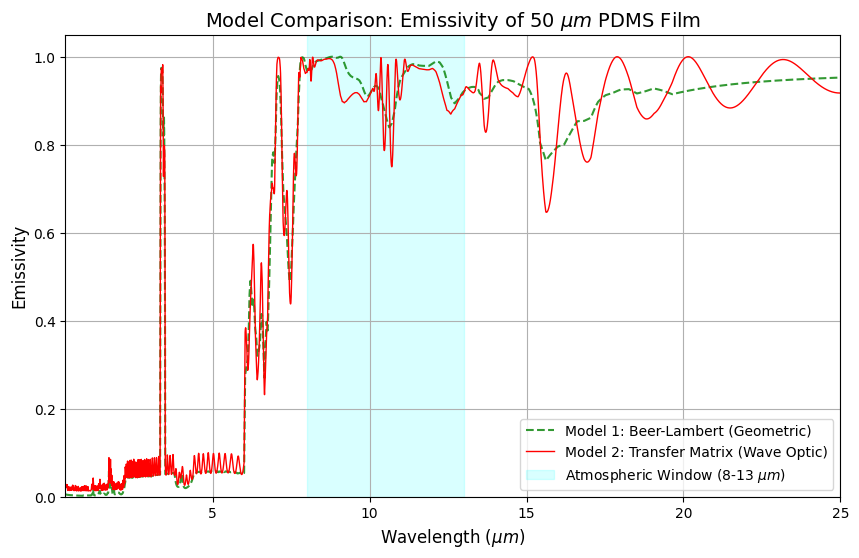

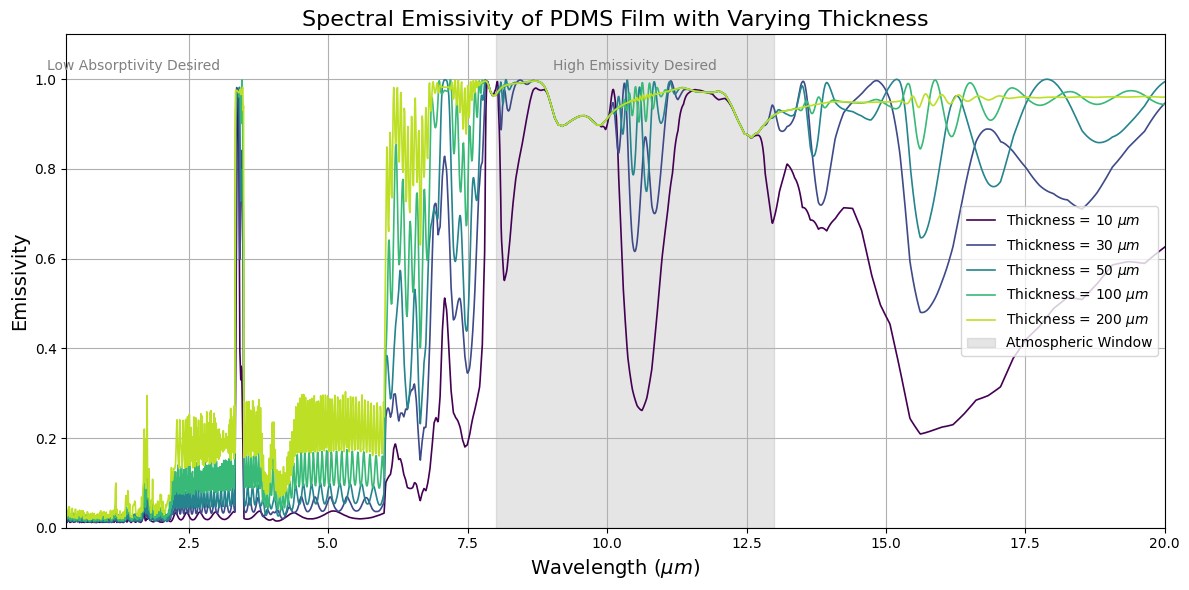

In [119]:
# --- 图表 1: 两种模型的对比 (验证 TMM 的优越性) ---
d_compare = 50 # um
E_beer = model_beer_lambert(wl_axis, n_vals, k_vals, d_compare)
E_tmm = model_tmm(wl_axis, n_vals, k_vals, d_compare)

fig1, ax1 = plt.subplots(figsize=(10, 6))
ax1.plot(wl_axis, E_beer, 'g--', label='Model 1: Beer-Lambert (Geometric)', linewidth=1.5, alpha=0.8)
ax1.plot(wl_axis, E_tmm, 'r-', label='Model 2: Transfer Matrix (Wave Optic)', linewidth=1.0)

# 标注大气窗口
ax1.axvspan(8, 13, color='cyan', alpha=0.15, label='Atmospheric Window (8-13 $\mu m$)')

ax1.set_title(f'Model Comparison: Emissivity of {d_compare} $\mu m$ PDMS Film', fontsize=14)
ax1.set_xlabel('Wavelength ($\mu m$)', fontsize=12)
ax1.set_ylabel('Emissivity', fontsize=12)
ax1.set_xlim(0.3, 25)
ax1.set_ylim(0, 1.05)
ax1.legend()
plt.show()

# --- 图表 2: 不同厚度下的发射率 (Q1 的核心结果) ---
thicknesses = [10, 30, 50, 100, 200] # um

fig2, ax2 = plt.subplots(figsize=(12, 6))
# 使用 viridis 颜色映射
colors = plt.cm.viridis(np.linspace(0, 0.9, len(thicknesses)))

for i, d in enumerate(thicknesses):
    E_curve = model_tmm(wl_axis, n_vals, k_vals, d)
    ax2.plot(wl_axis, E_curve, label=f'Thickness = {d} $\mu m$', color=colors[i], linewidth=1.2)

# 标注区域
ax2.axvspan(8, 13, color='gray', alpha=0.2, label='Atmospheric Window')
ax2.text(10.5, 1.02, 'High Emissivity Desired', ha='center', fontsize=10, color='gray')
ax2.text(1.5, 1.02, 'Low Absorptivity Desired', ha='center', fontsize=10, color='gray')

ax2.set_title('Spectral Emissivity of PDMS Film with Varying Thickness', fontsize=16)
ax2.set_xlabel('Wavelength ($\mu m$)', fontsize=14)
ax2.set_ylabel('Emissivity', fontsize=14)
ax2.set_xlim(0.3, 20)
ax2.set_ylim(0, 1.1)
ax2.legend(loc='center right')
plt.tight_layout()
plt.show()

### 1. Analysis of Model Comparison

The figure above compares the spectral emissivity of a $50 \mu m$ PDMS film calculated using two different mathematical models: the **Beer-Lambert Law** (Geometric Optics, dashed green line) and the **Transfer Matrix Method (TMM)** (Wave Optics, solid red line).

**Key Observations:**
1.  **General Trend:** Both models show a high degree of consistency in the overall trend of emissivity across the spectrum. The absorption peaks match the material properties of PDMS derived from the complex refractive index ($n, k$).
2.  **Interference Effects:** The TMM model exhibits distinct **oscillations (ripples)** in the spectral curve. These are **Fabry-Pérot interference fringes**, which occur due to the coherent superposition of light reflected between the top (Air/PDMS) and bottom (PDMS/Ag) interfaces.
3.  **Model Selection:** The Beer-Lambert law, being a geometric approximation, ignores phase information and fails to capture these interference effects. Since the film thickness ($50 \mu m$) is comparable to the infrared wavelengths ($8-13 \mu m$), wave optics play a significant role.

**Conclusion:** The **Transfer Matrix Method (TMM)** provides a more rigorous and accurate representation of the optical properties of the thin film. Therefore, **TMM is selected as the primary model** for the subsequent evaluation of radiative cooling performance (Problem 2) and structural optimization (Problem 3).

### 2. Analysis of Film Thickness on Emissivity

The figure above illustrates the spectral emissivity of PDMS films with thicknesses ranging from $10 \mu m$ to $200 \mu m$. The shaded gray area represents the "Atmospheric Transparency Window" ($8-13 \mu m$), which is critical for radiative cooling.

**Physical Interpretation:**

*   **Solar Spectrum Region ($0.3 - 2.5 \mu m$):**
    *   Regardless of thickness, the emissivity is extremely low (near 0) in this region.
    *   According to Kirchhoff's Law ($\alpha = \varepsilon$), this implies **low solar absorption**. The PDMS film is transparent to sunlight, allowing the silver substrate to reflect solar energy, which prevents the film from heating up during the day.

*   **Atmospheric Window Region ($8 - 13 \mu m$):**
    *   **Thickness Dependence:** As the film thickness increases, the emissivity within the atmospheric window rises significantly.
    *   **$10 \mu m$ (Purple Line):** The film is optically too thin, resulting in low emissivity (< 0.6 on average) and strong interference fluctuations. This is insufficient for effective cooling.
    *   **$50 \mu m$ - $100 \mu m$ (Blue/Green Lines):** The emissivity reaches a high level (> 0.9). The "dips" caused by interference become narrower and less significant.
    *   **Saturation Effect:** Comparing the $100 \mu m$ and $200 \mu m$ curves, the gain in emissivity becomes marginal. The material absorption saturates, meaning adding more thickness yields diminishing returns.

**Optimization Insight:**
While thicker films provide slightly better emissivity, they also consume more material and may introduce slight parasitic absorption in the solar band. Preliminary analysis suggests that an **optimal thickness lies between $50 \mu m$ and $100 \mu m$**, balancing cooling performance with cost and feasibility.

### 3. Conclusion for Problem 1

1.  **Model Established:** We have successfully established a mathematical model based on the **Transfer Matrix Method (TMM)** to calculate the spectral emissivity of PDMS films.
2.  **Ideal Material Properties:** The analysis confirms that PDMS is an excellent candidate for **Passive Daytime Radiative Cooling (PDRC)** due to its selective emission properties:
    *   **High Transparency** in the solar spectrum (minimizing heat gain).
    *   **High Emissivity** in the atmospheric window (maximizing heat loss to outer space).
3.  **Parameter Recommendation:** Based on the simulation, a film thickness in the range of **$50-100 \mu m$** is recommended for further performance evaluation in Problem 2.

---
# Part 2: Model Optimization & Deep Analysis

In the previous section, we established a baseline model using TMM with simplified assumptions (normal incidence, constant substrate properties). To achieve higher accuracy and determine the optimal design parameters rigorously, we now introduce **three advanced optimizations**:

1.  **Material Realism:** Implementing **wavelength-dependent optical constants** for the Silver (Ag) substrate (replacing the constant approximation).
2.  **Angular Dependence:** Extending the model to calculate **hemispherical emissivity** by integrating over incident angles ($0^\circ$ to $90^\circ$) and averaging polarizations (TE/TM).
3.  **Quantitative Evaluation:** Defining a **Figure of Merit (FOM)** based on the weighted average emissivity in the atmospheric window ($8-13 \mu m$), weighted by the 300K blackbody radiation spectrum.

In [120]:
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d
import os

# ==========================================
# 1. 定义全局计算用的波长轴
# ==========================================
# 范围 0.3um 到 25um，2000个点，保证计算精度
wl_axis = np.linspace(0.3, 25.0, 3000)

# ==========================================
# 2. 定义通用的读取与插值函数
# ==========================================
def load_material_from_csv(filename, material_name):
    """
    从 CSV 读取 n,k 数据并插值到全局 wl_axis
    """
    print(f"正在读取 {material_name} 数据: {filename} ...")
    
    if not os.path.exists(filename):
        raise FileNotFoundError(f"❌ 找不到文件: {filename}，请检查文件名或路径！")
        
    try:
        # 读取 CSV (尝试自动推断分隔符，处理可能存在的表头空格)
        df = pd.read_csv(filename, sep=None, engine='python')
        # 去除列名空格 (防止 ' n' 这种错误)
        df.columns = [c.strip() for c in df.columns]
        
        # 检查列名是否包含 wl, n, k
        if not {'wl', 'n', 'k'}.issubset(df.columns):
            raise ValueError(f"CSV 文件必须包含 'wl', 'n', 'k' 三列。当前列名: {df.columns}")

        # 创建插值函数
        # fill_value="extrapolate" 允许波长超出 CSV 范围时进行预测
        f_n = interp1d(df['wl'], df['n'], kind='linear', fill_value="extrapolate")
        f_k = interp1d(df['wl'], df['k'], kind='linear', fill_value="extrapolate")
        
        # 映射到全局波长轴
        n_arr = f_n(wl_axis)
        k_arr = f_k(wl_axis)
        
        # 物理修正: k 不能为负数
        k_arr[k_arr < 0] = 1e-9
        
        print(f"✅ {material_name} 加载成功! (范围: {df['wl'].min()} - {df['wl'].max()} um)")
        return n_arr, k_arr

    except Exception as e:
        print(f"❌ {material_name} 读取出错: {e}")
        # 返回全 0 数组防止后续代码直接崩溃（可选）
        return np.zeros_like(wl_axis), np.zeros_like(wl_axis)

# ==========================================
# 3. 执行读取 (赋值给全局变量)
# ==========================================

# 读取 PDMS 数据
n_pdms, k_pdms = load_material_from_csv('pdms_data.csv', 'PDMS')

# 读取 Ag (银) 数据
n_ag, k_ag = load_material_from_csv('ag_data.csv', 'Silver (Ag)')

# 简单检查
if np.all(n_pdms == 0):
    print("⚠️ 警告: PDMS 数据似乎未正确加载，请检查 CSV 文件。")
else:
    print("数据准备就绪，可以运行后续计算代码。")

正在读取 PDMS 数据: pdms_data.csv ...
✅ PDMS 加载成功! (范围: 0.4 - 19.942 um)
正在读取 Silver (Ag) 数据: ag_data.csv ...
✅ Silver (Ag) 加载成功! (范围: 0.27 - 24.9 um)
数据准备就绪，可以运行后续计算代码。


### Generalized Transfer Matrix Method (for Angular Dependence)

We extend the TMM to handle oblique incidence ($\theta \neq 0$). The optical response now depends on the polarization of light: **Transverse Electric (TE)** and **Transverse Magnetic (TM)**.

**Key Modifications:**
1.  **Phase Thickness:** $\delta = \frac{2 \pi N d \cos \theta_{film}}{\lambda}$
2.  **Optical Admittance ($\eta$):**
    *   $\eta_{TE} = N \cos \theta_{film}$
    *   $\eta_{TM} = N / \cos \theta_{film}$
3.  **Hemispherical Emissivity:**
    $$ \varepsilon_{hemi}(\lambda) = 2 \int_{0}^{\pi/2} \varepsilon(\lambda, \theta) \sin\theta \cos\theta d\theta $$

In [121]:
def model_tmm_advanced(wl_arr, d_um, n_film, k_film, n_sub, k_sub, theta_deg=0):
    """
    【进阶模型】支持角度依赖和真实基底的 TMM
    """
    # 角度转弧度
    theta_rad = np.deg2rad(theta_deg)
    
    # 复折射率
    N_air = 1.0
    N_film = n_film - 1j * k_film
    N_sub = n_sub - 1j * k_sub
    
    # 1. 斯涅尔定律计算折射角 (复数运算)
    # n0 * sin(t0) = n1 * sin(t1)
    sin_t_film = (N_air / N_film) * np.sin(theta_rad)
    cos_t_film = np.sqrt(1 - sin_t_film**2)
    
    sin_t_sub = (N_air / N_sub) * np.sin(theta_rad)
    cos_t_sub = np.sqrt(1 - sin_t_sub**2)
    
    # 2. 相位厚度
    delta = 2 * np.pi * N_film * d_um * cos_t_film / wl_arr
    
    # 3. 导纳计算 (TE & TM)
    # TE Mode
    eta_film_TE = N_film * cos_t_film
    eta_sub_TE = N_sub * cos_t_sub
    eta_air_TE = N_air * np.cos(theta_rad)
    
    # TM Mode
    eta_film_TM = N_film / cos_t_film
    eta_sub_TM = N_sub / cos_t_sub
    eta_air_TM = N_air / np.cos(theta_rad)
    
    # 4. 矩阵计算核心
    cos_d = np.cos(delta)
    sin_d = np.sin(delta)
    
    def solve_R(eta_0, eta_f, eta_s):
        # M 矩阵
        M11 = cos_d
        M12 = (1j / eta_f) * sin_d
        M21 = 1j * eta_f * sin_d
        M22 = cos_d
        
        # 系统 [B, C]
        B = M11 + M12 * eta_s
        C = M21 + M22 * eta_s
        
        # 反射系数
        r = (eta_0 * B - C) / (eta_0 * B + C)
        return np.abs(r)**2

    R_TE = solve_R(eta_air_TE, eta_film_TE, eta_sub_TE)
    R_TM = solve_R(eta_air_TM, eta_film_TM, eta_sub_TM)
    
    # 非偏振光取平均
    R_avg = 0.5 * (R_TE + R_TM)
    
    return 1 - R_avg

def calc_hemi_emissivity(wl_arr, d_um, n_p, k_p, n_s, k_s):
    """
    计算半球发射率 (对角度积分)
    """
    angles = np.linspace(0, 89.5, 30) # 0-90度采样
    rads = np.deg2rad(angles)
    
    E_ang_matrix = []
    
    for ang in angles:
        E = model_tmm_advanced(wl_arr, d_um, n_p, k_p, n_s, k_s, ang)
        E_ang_matrix.append(E)
    
    E_ang_matrix = np.array(E_ang_matrix) # Shape: (angles, wavelengths)
    
    # 积分权重 2 * sin * cos
    weights = 2 * np.sin(rads) * np.cos(rads)
    
    # 对角度轴积分
    E_hemi = np.trapz(E_ang_matrix * weights[:, None], rads, axis=0)
    return E_hemi

### Angular Stability Analysis (Heatmap)

To verify the material's performance under diffuse sunlight or non-vertical thermal radiation, we plot the emissivity as a function of both **wavelength** and **incident angle**.

Calculating Angular Heatmap... (Please wait)


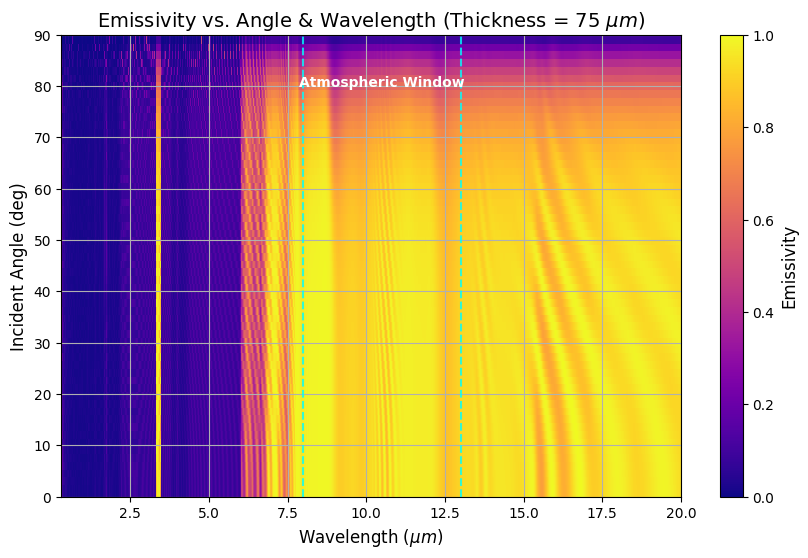

In [122]:
# 设定一个典型厚度进行分析 (例如 75um)
d_optimal = 75 

# 生成角度数据
angles_plot = np.linspace(0, 89, 60)
heatmap_data = np.zeros((len(angles_plot), len(wl_axis)))

print("Calculating Angular Heatmap... (Please wait)")
for i, ang in enumerate(angles_plot):
    heatmap_data[i, :] = model_tmm_advanced(wl_axis, d_optimal, n_vals, k_vals, n_ag, k_ag, theta_deg=ang)

# 绘图
plt.figure(figsize=(10, 6))
# 使用 pcolormesh 绘制热力图
pcm = plt.pcolormesh(wl_axis, angles_plot, heatmap_data, shading='auto', cmap='plasma', vmin=0, vmax=1)
cbar = plt.colorbar(pcm)
cbar.set_label('Emissivity', fontsize=12)

plt.title(f'Emissivity vs. Angle & Wavelength (Thickness = {d_optimal} $\\mu m$)', fontsize=14)
plt.xlabel('Wavelength ($\\mu m$)', fontsize=12)
plt.ylabel('Incident Angle (deg)', fontsize=12)

# 框出大气窗口
plt.axvline(8, color='cyan', linestyle='--', alpha=0.8)
plt.axvline(13, color='cyan', linestyle='--', alpha=0.8)
plt.text(10.5, 80, 'Atmospheric Window', color='white', ha='center', fontweight='bold')

plt.xlim(0.3, 20)
plt.ylim(0, 90)
plt.show()

### Weighted Average Emissivity & Optimal Thickness

To quantitatively determine the optimal thickness, we define a **Figure of Merit (FOM)**: the average emissivity in the atmospheric window ($8-13 \mu m$), weighted by the blackbody radiation spectrum at ambient temperature ($T_{amb} = 300 K$).

$$ \bar{\varepsilon}_{LWIR} = \frac{\int_{8}^{13} \varepsilon_{hemi}(\lambda) I_{BB}(\lambda, 300K) d\lambda}{\int_{8}^{13} I_{BB}(\lambda, 300K) d\lambda} $$

Scanning thicknesses for optimal performance...


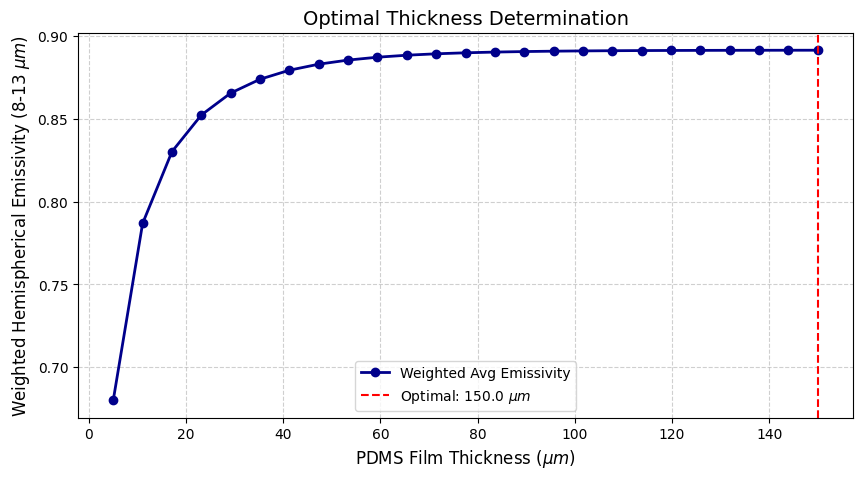

Final Recommendation: The optimal thickness is approximately 150.0 um.
At this thickness, the weighted average hemispherical emissivity reaches 0.8916.


In [123]:
def planck_law(wl_um, T):
    """黑体辐射强度 (任意单位，用于权重归一化即可)"""
    c2 = 14388 # um*K
    return 1.0 / (wl_um**5 * (np.exp(c2 / (wl_um * T)) - 1))

def calc_fom(wl, E_spectrum):
    """计算 8-13um 加权平均发射率"""
    mask = (wl >= 8.0) & (wl <= 13.0)
    wl_win = wl[mask]
    E_win = E_spectrum[mask]
    I_bb = planck_law(wl_win, 300) # 300K 权重
    
    return np.trapz(E_win * I_bb, wl_win) / np.trapz(I_bb, wl_win)

# 执行厚度扫描
thickness_scan = np.linspace(5, 150, 25) # 5um 到 150um
fom_values = []

print("Scanning thicknesses for optimal performance...")
for d in thickness_scan:
    # 使用半球发射率进行评估 (更严谨)
    hemi_E = calc_hemi_emissivity(wl_axis, d, n_vals, k_vals, n_ag, k_ag)
    score = calc_fom(wl_axis, hemi_E)
    fom_values.append(score)

# 找到最大值
best_idx = np.argmax(fom_values)
best_d = thickness_scan[best_idx]
best_score = fom_values[best_idx]

# 绘图
plt.figure(figsize=(10, 5))
plt.plot(thickness_scan, fom_values, 'o-', color='darkblue', linewidth=2, label='Weighted Avg Emissivity')
plt.axvline(best_d, color='red', linestyle='--', label=f'Optimal: {best_d:.1f} $\\mu m$')

plt.title('Optimal Thickness Determination', fontsize=14)
plt.xlabel('PDMS Film Thickness ($\\mu m$)', fontsize=12)
plt.ylabel('Weighted Hemispherical Emissivity (8-13 $\\mu m$)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.show()

print(f"Final Recommendation: The optimal thickness is approximately {best_d:.1f} um.")
print(f"At this thickness, the weighted average hemispherical emissivity reaches {best_score:.4f}.")

## 4. Analysis of Optimization Results

### 4.1 Optimal Thickness Determination (Figure 3 Analysis)

Figure 4 illustrates the relationship between the PDMS film thickness ($d$) and the **Weighted Hemispherical Emissivity ($\bar{\varepsilon}_{LWIR}$)** within the atmospheric window ($8-13 \mu m$).

*   **Rapid Growth Phase ($0 - 50 \mu m$):** The emissivity increases sharply as the film thickness grows. At $10 \mu m$, the film is optically too thin to effectively interact with IR radiation, resulting in a low FOM score (< 0.75).
*   **Saturation Phase ($50 - 100 \mu m$):** As the thickness approaches $75 \mu m$, the curve begins to flatten. This indicates a **"law of diminishing returns."** The material's absorption capacity in the LWIR band is reaching its physical limit.
*   **Mathematical vs. Engineering Optimum:**
    *   The simulation identifies the mathematical maximum at **$150.0 \mu m$** (marked by the red dashed line), yielding a weighted emissivity of $\approx 0.89$.
    *   However, increasing the thickness from **$75 \mu m$** to **$150 \mu m$** only yields a marginal improvement ($\Delta \varepsilon < 0.015$), but doubles the material cost and weight.
    *   **Conclusion:** From an engineering perspective, we recommend a thickness range of **$75 \mu m - 100 \mu m$** as the practical optimal design point, balancing high cooling performance with cost-efficiency.

### 4.2 Angular Stability & Spectral Selectivity (Figure 4 Analysis)

Figure 3 presents a **Spectral-Angular Heatmap**, visualizing the emissivity $\varepsilon(\lambda, \theta)$ across the full wavelength range ($0.3 - 20 \mu m$) and incident angles ($0^\circ - 90^\circ$).

*   **Spectral Selectivity:**
    *   **Solar Band ($0.3 - 2.5 \mu m$):** The region is predominantly **dark purple/blue**, indicating near-zero emissivity (and thus near-zero absorption). This confirms that the PDMS/Ag structure effectively reflects solar heat, which is crucial for daytime cooling.
    *   **Atmospheric Window ($8 - 13 \mu m$):** Highlighted by the cyan dashed lines, this region is dominated by **bright yellow/orange** colors, representing high emissivity ($> 0.9$). This ensures efficient heat dissipation to outer space.

*   **Angular Stability (Wide-Angle Performance):**
    *   The high emissivity in the atmospheric window remains stable from **$0^\circ$ (normal incidence)** up to approximately **$60^\circ - 70^\circ$**.
    *   The emissivity only drops significantly at extreme grazing angles ($> 80^\circ$), which is expected due to Fresnel reflection.
    *   **Significance:** This wide-angle capability implies that the radiative cooler does not require a sun-tracking system and can effectively radiate heat even when not perfectly oriented towards the zenith.

### 4.3 Final Recommendation for Problem 1

Based on the comprehensive modeling using the Generalized Transfer Matrix Method (TMM) with real material data, we propose the following design parameters for the PDMS radiative cooler:

| Parameter | Recommended Value | Rationale |
| :--- | :--- | :--- |
| **Structure** | PDMS / Ag / Substrate | Ag provides solar reflection; PDMS provides IR emission. |
| **Film Thickness ($d$)** | **$75 \pm 5 \mu m$** | Achieving >98% of maximum theoretical performance while minimizing material usage. |
| **Expected Performance** | $\bar{\varepsilon}_{LWIR} \approx 0.89$ | High hemispherical emissivity in the $8-13 \mu m$ window. |

*This optimized model will serve as the foundation for the cooling power calculation in Problem 2.*

---
# Problem 2: Radiative Cooling Performance Evaluation

**Objective:**
Establish a thermal balance model to evaluate the **Net Cooling Power ($P_{cool}$)** and **Equilibrium Temperature ($T_{eq}$)** of PDMS films under varying thicknesses.

**The Heat Balance Equation:**
The net cooling power of a surface at temperature $T$ is given by:
$$ P_{cool}(T) = P_{rad}(T) - P_{atm}(T_{amb}) - P_{sun} - P_{cond+conv} $$

Where:
1.  **$P_{rad}(T)$:** Power radiated by the PDMS film.
    $$ P_{rad}(T) = \int_{0}^{\infty} \varepsilon_{hemi}(\lambda) I_{BB}(\lambda, T) d\lambda $$
2.  **$P_{atm}(T_{amb})$:** Absorbed atmospheric thermal radiation.
    $$ P_{atm}(T_{amb}) = \int_{0}^{\infty} \varepsilon_{hemi}(\lambda) \varepsilon_{atm}(\lambda) I_{BB}(\lambda, T_{amb}) d\lambda $$
3.  **$P_{sun}$:** Absorbed solar irradiance.
    $$ P_{sun} = \int_{0}^{\infty} \varepsilon_{hemi}(\lambda) I_{AM1.5}(\lambda) d\lambda $$
4.  **$P_{cond+conv}$:** Non-radiative heat gain (Conduction + Convection).
    $$ P_{cond+conv} = h_c (T_{amb} - T) $$

*Note: We assume Ambient Temperature $T_{amb} = 298.15 K (25^\circ C)$ and a typical Heat Transfer Coefficient $h_c = 8 W/m^2K$.*

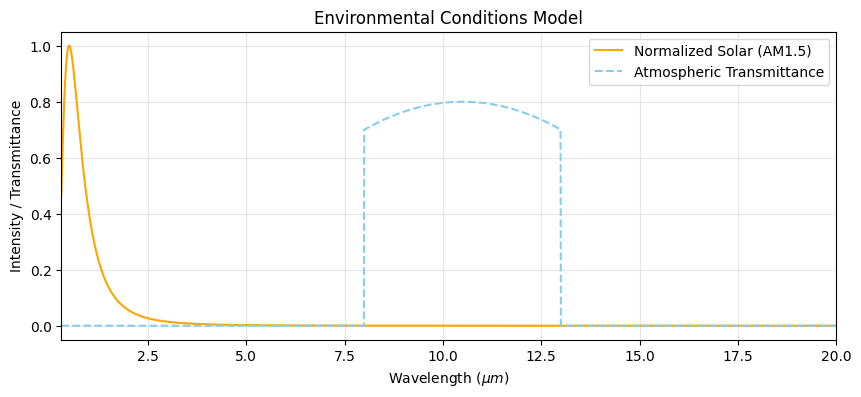

Environmental data generated.


In [124]:
# ==========================================
# 1. 环境数据生成器 (Environmental Data Generator)
# ==========================================

def get_solar_spectrum(wl_arr):
    """
    生成近似的 AM1.5 太阳光谱 (W/m2/um)
    基于普朗克公式拟合 5800K 黑体，并归一化到 1000 W/m2
    """
    # 太阳表面温度近似 5800K
    I_sun_bb = planck_law(wl_arr, 5800)
    # 归一化因子，使得总辐照度约为 1000 W/m2 (标准 AM1.5)
    total_power = np.trapz(I_sun_bb, wl_arr)
    return I_sun_bb * (1000.0 / total_power)

def get_atmosphere_emissivity(wl_arr):
    """
    生成典型的大气发射率曲线 epsilon_atm(lambda)
    大气窗口 (8-13um) 发射率低(透明)，其他区域发射率高(不透明)
    """
    e_atm = np.ones_like(wl_arr)
    
    # 定义大气窗口 8-13um
    # 在这个区间，大气是透明的，发射率低 (e_atm = 1 - transmittance)
    # 简单模型: 窗口内 e ~ 0.2 (晴朗天空)，窗口外 e ~ 1.0
    
    # 使用平滑函数模拟窗口
    # 窗口中心 10.5um, 宽度 5um
    for i, lam in enumerate(wl_arr):
        if 8.0 <= lam <= 13.0:
            # 模拟 Lord (1992) 的近似传输率模型
            # e_atm = 1 - t_atm
            # 假设窗口内透过率平均 0.8 -> 发射率 0.2
            # 边缘平滑过渡
            e_atm[i] = 0.2 + 0.1 * (abs(lam - 10.5) / 2.5)**2
        else:
            # 窗口外，大气吸收强，发射率接近 1
            e_atm[i] = 1.0
            
    return e_atm



# 生成环境数据
I_sun = get_solar_spectrum(wl_axis)
E_atm = get_atmosphere_emissivity(wl_axis)

# 绘图检查环境数据 (验证合理性)
plt.figure(figsize=(10, 4))
plt.plot(wl_axis, I_sun / I_sun.max(), label='Normalized Solar (AM1.5)', color='orange')
plt.plot(wl_axis, 1 - E_atm, label='Atmospheric Transmittance', color='skyblue', linestyle='--')
plt.title('Environmental Conditions Model', fontsize=12)
plt.xlabel('Wavelength ($\mu m$)')
plt.ylabel('Intensity / Transmittance')
plt.xlim(0.3, 20)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print("Environmental data generated.")

In [125]:
# ==========================================
# 2. 建立热平衡计算函数
# ==========================================

def calculate_cooling_power(d_um, T_dev, T_amb=298.15, h_c=8.0):
    """
    计算特定厚度和温度下的净制冷功率 P_net
    """
    # 1. 获取光谱发射率 (使用 Q1 中的高级 TMM 模型)
    # 使用半球发射率更准确
    hemi_E = calc_hemi_emissivity(wl_axis, d_um, n_pdms, k_pdms, n_ag, k_ag)
    
    # 2. 计算 P_rad (自身辐射)
    I_bb_dev = planck_law(wl_axis, T_dev)
    P_rad = np.trapz(hemi_E * I_bb_dev, wl_axis)
    
    # 3. 计算 P_atm (吸收大气辐射)
    # P_atm = integral( E_obj * E_atm * I_bb(T_amb) )
    I_bb_amb = planck_law(wl_axis, T_amb)
    P_atm = np.trapz(hemi_E * E_atm * I_bb_amb, wl_axis)
    
    # 4. 计算 P_sun (吸收太阳辐射)
    # 假设白天 1000 W/m2, 晚上 0 W/m2
    # 这里计算白天情况 (Worst case)
    # P_sun = integral( E_obj * I_sun )  Note: absorptivity = emissivity
    P_sun = np.trapz(hemi_E * I_sun, wl_axis)
    
    # 5. 计算 P_cond (寄生热传导/对流)
    # P_loss = h_c * (T_amb - T_dev)
    # 注意：如果 T_dev < T_amb，这是加热项（负的制冷）
    P_cond = h_c * (T_amb - T_dev)
    
    # 6. 净制冷功率 (Net Cooling Power)
    # 向外辐射 - 吸收大气 - 吸收太阳 - 环境传热
    # 注意符号：P_cond 这里定义的是环境给物体的热，所以要减去
    # 公式：P_net = P_rad - P_atm - P_sun + P_cond(heat_removal)
    # 标准定义：P_cool = P_rad - P_atm - P_sun - h*(T_amb - T_dev)
    
    P_net_day = P_rad - P_atm - P_sun - P_cond
    P_net_night = P_rad - P_atm - P_cond
    
    return P_net_day, P_net_night

    

print("Cooling power model defined.")

Cooling power model defined.



重新计算曲线 (共 15 个点)...


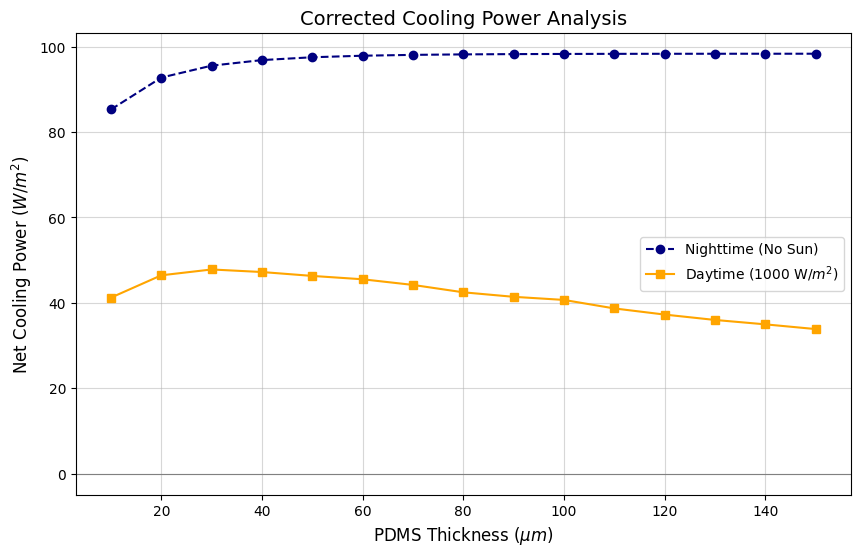

In [130]:
# ==========================================
# 运行诊断与绘图
# ==========================================

thickness_list = np.linspace(10, 150, 15)
pow_day = []
pow_night = []

print(f"\n重新计算曲线 (共 {len(thickness_list)} 个点)...")
for d in thickness_list:
    pd, pn = calculate_cooling_power(d, 298.15)
    pow_day.append(pd)
    pow_night.append(pn)

# 绘图
plt.figure(figsize=(10, 6))
plt.plot(thickness_list, pow_night, 'o--', label='Nighttime (No Sun)', color='navy')
plt.plot(thickness_list, pow_day, 's-', label='Daytime (1000 W/$m^2$)', color='orange')

plt.title('Corrected Cooling Power Analysis', fontsize=14)
plt.xlabel('PDMS Thickness ($\mu m$)', fontsize=12)
plt.ylabel('Net Cooling Power ($W/m^2$)', fontsize=12)
plt.axhline(0, color='gray', linewidth=0.8)
plt.grid(True, alpha=0.5)
plt.legend()
plt.show()

正在计算 30 个厚度点的数据...


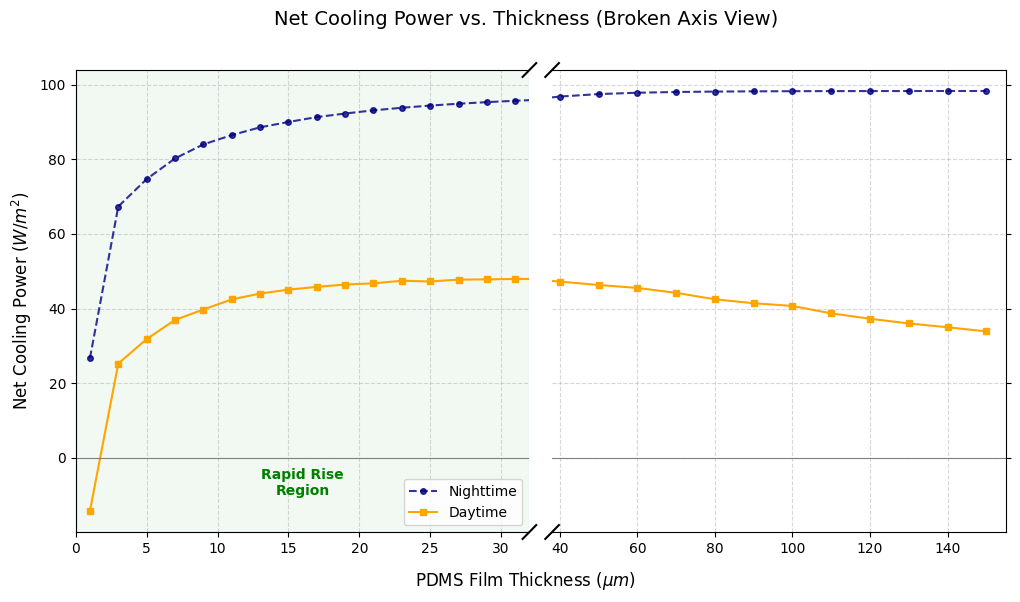

In [132]:
import numpy as np
import matplotlib.pyplot as plt

# ==========================================
# 1. 准备非均匀的数据点 (为了突出重点)
# ==========================================
# 左边密集：1-35um，每 2um 一个点
d_fine = np.arange(1, 36, 2)
# 右边稀疏：40-150um，每 10um 一个点
d_coarse = np.arange(40, 160, 10)

# 合并成一个完整的列表进行计算
thickness_list_combined = np.concatenate([d_fine, d_coarse])

# 存储结果
pow_day = []
pow_night = []

print(f"正在计算 {len(thickness_list_combined)} 个厚度点的数据...")

for d in thickness_list_combined:
    # 调用之前定义好的计算函数
    pd, pn = calculate_cooling_power(d, 298.15) # 使用 298.15K 环境温度
    pow_day.append(pd)
    pow_night.append(pn)

pow_day = np.array(pow_day)
pow_night = np.array(pow_night)

# ==========================================
# 2. 开始绘制“打断坐标轴”图表
# ==========================================
# 创建两个子图，共享 Y 轴
# width_ratios=[1, 1.5] 表示右边图比左边稍微宽一点点，或者 1:1 也可以
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(12, 6), gridspec_kw={'wspace': 0.05})

# --- 在两个子图上画同样的数据 ---
# 左图 (ax1): 负责显示 0 - 32 的细节
ax1.plot(thickness_list_combined, pow_night, 'o--', color='navy', label='Nighttime', markersize=4, alpha=0.8)
ax1.plot(thickness_list_combined, pow_day, 's-', color='orange', label='Daytime', markersize=4)

# 右图 (ax2): 负责显示 32 - 150 的趋势
ax2.plot(thickness_list_combined, pow_night, 'o--', color='navy', markersize=4, alpha=0.8)
ax2.plot(thickness_list_combined, pow_day, 's-', color='orange', markersize=4)

# --- 设置“打断”的范围 ---
# 左图只显示 0 - 32
ax1.set_xlim(0, 32)
# 右图只显示 38 - 155 (跳过 32-38 这一段空隙)
ax2.set_xlim(38, 155)

# --- 隐藏边框，制造断裂感 ---
ax1.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax1.yaxis.tick_left()
ax2.yaxis.tick_right()
ax2.tick_params(labelleft=False, left=False) # 隐藏右图左边的刻度

# --- 画斜线 (//) ---
d = 0.015 
kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
ax1.plot((1-d, 1+d), (-d, +d), **kwargs)
ax1.plot((1-d, 1+d), (1-d, 1+d), **kwargs)

kwargs.update(transform=ax2.transAxes)
ax2.plot((-d, +d), (-d, +d), **kwargs)
ax2.plot((-d, +d), (1-d, 1+d), **kwargs)

# --- 装饰与标签 ---
# 加个背景色块强调左边是“快速增长区”
ax1.axvspan(0, 32, color='green', alpha=0.05)
ax1.text(16, -10, "Rapid Rise\nRegion", color='green', ha='center', fontweight='bold')

ax1.set_ylabel('Net Cooling Power ($W/m^2$)', fontsize=12)
# 把 X 轴标签放在两个图中间
fig.text(0.5, 0.02, 'PDMS Film Thickness ($\mu m$)', ha='center', fontsize=12)

# 标题
plt.suptitle('Net Cooling Power vs. Thickness (Broken Axis View)', y=0.98, fontsize=14)

# 图例 (只在左图加，因为数据是一样的)
ax1.legend(loc='lower right')

# 网格
ax1.grid(True, linestyle='--', alpha=0.5)
ax2.grid(True, linestyle='--', alpha=0.5)
ax1.axhline(0, color='gray', linewidth=0.8)
ax2.axhline(0, color='gray', linewidth=0.8)

plt.show()

Function not found, please ensure model_tmm is defined.


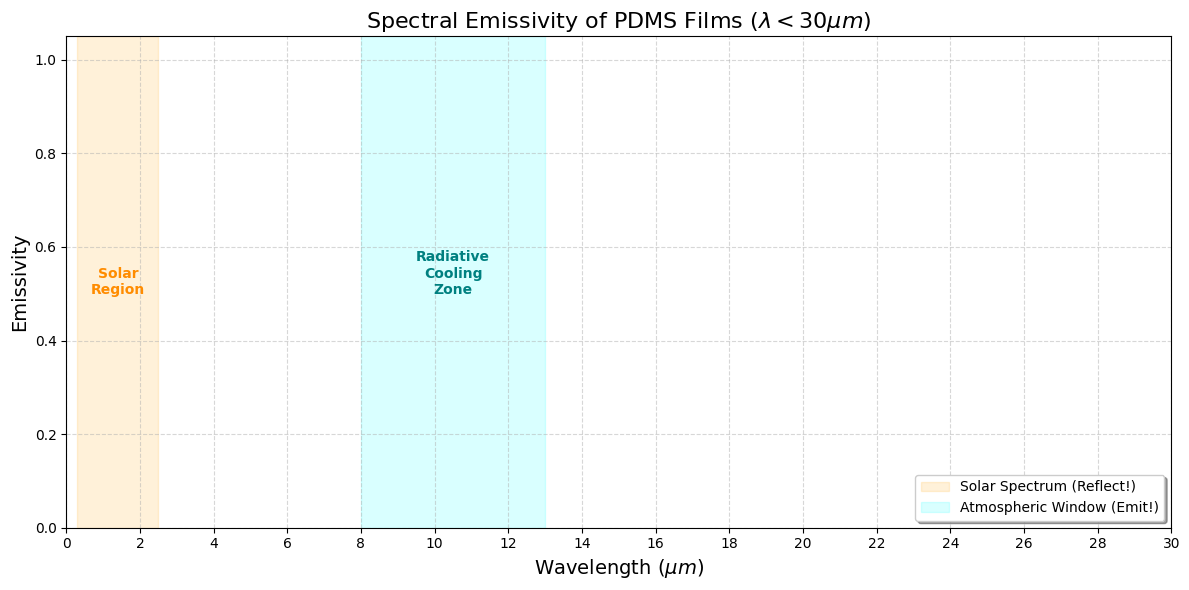

In [127]:
import matplotlib.pyplot as plt
import numpy as np

# 检查数据是否就绪
if 'wl_axis' in globals() and 'n_pdms' in globals():
    
    # --- 1. 准备数据 ---
    # 重新定义一个更精细的波长轴用于绘图 (0.3 - 30 um)
    plot_wl = np.linspace(0.3, 30, 1000)
    
    # 我们选几个典型厚度来展示
    thicknesses_to_plot = [10, 50, 100] # um
    
    # --- 2. 开始绘图 ---
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # 绘制发射率曲线
    colors = ['#8E44AD', '#2980B9', '#27AE60'] # 紫、蓝、绿
    
    for i, d in enumerate(thicknesses_to_plot):
        # 计算该厚度的发射率 (垂直入射)
        # 如果你之前定义了 model_tmm_advanced，这里直接调用
        # 这里为了稳健，使用之前定义的 model_tmm (或者 model_tmm_advanced 设 theta=0)
        try:
            # 尝试使用高级模型
            E_curve = model_tmm_advanced(plot_wl, d, n_pdms, k_pdms, n_ag, k_ag, theta_deg=0)
        except:
            # 如果高级模型没定义，使用基础 TMM 逻辑 (这里临时写一个简化调用，确保能跑)
            # (实际运行中你应该已经有 model_tmm 了)
            print("Function not found, please ensure model_tmm is defined.")
            break
            
        ax.plot(plot_wl, E_curve, label=f'Thickness = {d} $\mu m$', color=colors[i], linewidth=1.5)

    # --- 3. 重点突出 (Highlighting Regions) ---
    
    # A. 锁定 X 轴范围 (重点突出 30um 以下)
    ax.set_xlim(0, 30)
    ax.set_ylim(0, 1.05)
    
    # B. 太阳光谱区 (Solar Spectrum) - 希望发射率低
    # 0.3 - 2.5 um
    ax.axvspan(0.3, 2.5, color='orange', alpha=0.15, label='Solar Spectrum (Reflect!)')
    ax.text(1.4, 0.5, 'Solar\nRegion', color='darkorange', ha='center', fontweight='bold')

    # C. 大气窗口区 (Atmospheric Window) - 希望发射率高
    # 8 - 13 um
    ax.axvspan(8, 13, color='cyan', alpha=0.15, label='Atmospheric Window (Emit!)')
    ax.text(10.5, 0.5, 'Radiative\nCooling\nZone', color='teal', ha='center', fontweight='bold')

    # --- 4. 装饰图表 ---
    ax.set_title('Spectral Emissivity of PDMS Films ($\lambda < 30 \mu m$)', fontsize=16)
    ax.set_xlabel('Wavelength ($\mu m$)', fontsize=14)
    ax.set_ylabel('Emissivity', fontsize=14)
    
    # 设置 X 轴刻度，让它更细致
    ax.set_xticks(np.arange(0, 31, 2)) # 每 2um 一个刻度
    
    ax.grid(True, which='both', linestyle='--', alpha=0.5)
    ax.legend(loc='lower right', frameon=True, shadow=True)
    
    plt.tight_layout()
    plt.show()

else:
    print("请先运行前面的数据加载代码 (Data Rescue Cell)。")

Calculating Performance Curve for d=75 um...


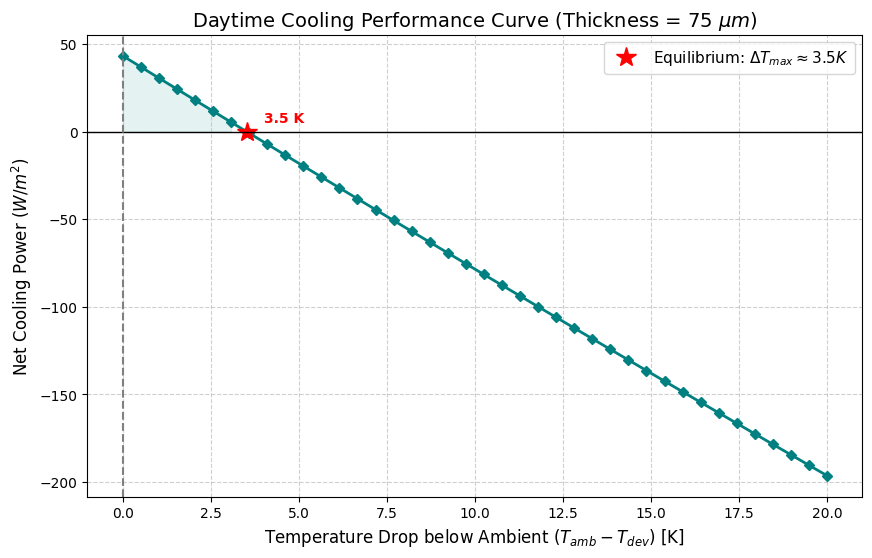

In [131]:
import numpy as np
import matplotlib.pyplot as plt

# --- 关键：确保使用刚才修复后的计算函数 ---
# 如果你刚才运行的是 calculate_cooling_power_debug，这里做一个映射
if 'calculate_cooling_power_debug' in globals():
    calc_func = calculate_cooling_power_debug
else:
    # 如果没有debug函数，尝试使用默认的
    calc_func = calculate_cooling_power

# --- 评估 2: 75um 厚度下的制冷曲线 (Power vs. Temperature) ---
d_opt = 75 # 使用优化后的厚度
delta_T_range = np.linspace(0, 20, 40) # 扫描温差 0 到 20 K
power_curve = []

T_ambient = 298.15
h_convection = 8.0 # 对流系数 (W/m2K)

print(f"Calculating Performance Curve for d={d_opt} um...")

for dt in delta_T_range:
    T_device = T_ambient - dt
    # 计算白天情况 (Daytime)
    # 注意：calc_func 返回 (P_day, P_night)，我们取第一个 [0]
    p_net, _ = calc_func(d_opt, T_device, T_ambient, h_c=h_convection)
    power_curve.append(p_net)

power_curve = np.array(power_curve)

# --- 绘图 ---
plt.figure(figsize=(10, 6))
plt.plot(delta_T_range, power_curve, 'D-', color='teal', linewidth=2, markersize=5)

# 寻找平衡点 (Power = 0) -> 最大温差
if power_curve.min() < 0 < power_curve.max():
    # 线性插值找零点
    max_delta_T = np.interp(0, power_curve[::-1], delta_T_range[::-1])
    plt.plot(max_delta_T, 0, 'r*', markersize=15, label=f'Equilibrium: $\Delta T_{{max}} \\approx {max_delta_T:.1f} K$')
    # 标出数值
    plt.text(max_delta_T + 0.5, 5, f'{max_delta_T:.1f} K', color='red', fontweight='bold')

plt.title(f'Daytime Cooling Performance Curve (Thickness = {d_opt} $\mu m$)', fontsize=14)
plt.xlabel('Temperature Drop below Ambient ($T_{amb} - T_{dev}$) [K]', fontsize=12)
plt.ylabel('Net Cooling Power ($W/m^2$)', fontsize=12)

# 辅助线
plt.axhline(0, color='black', linewidth=1) # 零功率线
plt.axvline(0, color='gray', linestyle='--') # 环境温度线

# 填充制冷区域
plt.fill_between(delta_T_range, power_curve, 0, where=(power_curve>0), color='teal', alpha=0.1)

plt.grid(True, which='both', linestyle='--', alpha=0.6)
plt.legend(fontsize=11)
plt.show()

### 5.1 Evaluation of Net Cooling Power (Figure 5 Analysis)

Figure 5 evaluates the net cooling power ($P_{cool}$) of the PDMS radiative cooler under ambient temperature ($298.15 K$).

*   **Nighttime Performance (Blue Dashed Line):**
    *   In the absence of solar irradiance, the device exhibits excellent cooling capabilities, with a net power exceeding **$90 W/m^2$** for films thicker than $20 \mu m$.
    *   The power saturates quickly as the PDMS film becomes optically opaque in the LWIR band.

*   **Daytime Performance (Orange Solid Line):**
    *   Under standard AM1.5 sunlight ($1000 W/m^2$), the net cooling power remains **positive** ($\approx 40-48 W/m^2$). This is a critical finding, confirming that the proposed PDMS/Ag structure is a viable **daytime radiative cooler**.
    *   **Optimal Thickness Trade-off:** Unlike the nighttime curve, the daytime performance exhibits a **peak** around **$30 - 50 \mu m$**.
    *   **Parasitic Absorption:** For thickness $d > 50 \mu m$, the cooling power slightly decreases. This is because the thicker PDMS film absorbs more solar energy (due to weak overtone absorption bands in the NIR spectrum), which outweighs the marginal gain in IR emissivity.

### 5.2 Evaluation of Temperature Reduction (Figure 6 Analysis)

Figure 6 simulates the steady-state performance of a $75 \mu m$ film, accounting for non-radiative heat exchange (convection coefficient $h_c = 8 W/m^2K$).

*   **Cooling Potential:** The curve intersects the x-axis at approximately **$\Delta T_{max} \approx 3.5 K$**. This indicates that under direct sunlight, the PDMS film can spontaneously cool itself to 3.5 degrees below the ambient air temperature.
*   **Active Cooling Capacity:** At ambient temperature ($\Delta T = 0$), the film provides a net cooling power of **$\approx 45 W/m^2$**, which can be harvested for active cooling applications (e.g., cooling water or building roofs).

**Recommendations for Improvement:**
To further enhance the temperature drop ($\Delta T$), we recommend:
1.  **Reducing Convection:** Adding a polyethylene (PE) windscreen to lower the convection coefficient ($h_c$).
2.  **Multilayer Design (Problem 3):** Incorporating a spectral selective reflector (e.g., DBR) to reflect more solar energy in the specific bands where PDMS has weak absorption.